# Combining InSAR Data From Different Tracks and Orbits

## Setup

In [1]:
%matplotlib inline
import glob
import numpy as np
import sys
import shutil
from itertools import product
from pathlib import Path
from skimage import morphology

import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [20]:
cd ~/work/combined

/home/micromamba/work/combined


In [3]:
tracks = ['asc','desc']
years = [2018,2019,2020,2021]
# tracks = ['desc']
# years = [2020,2021]

In [34]:
!rm ~/work/asclower/maskTempCoh_ascupper.h5

In [30]:
!ls ~/work/asclower

avgSpatialCoh.h5		    temporalCoherence_asclower_2020.h5
coherenceSpatialAvg.txt		    temporalCoherence_asclower_2021.h5
dask-worker-space		    timeseries_asclower_2018.h5
hyp3.cfg			    timeseries_asclower_2019.h5
maskTempCoh_asclower.h5		    timeseries_asclower_2020.h5
maskTempCoh_ascupper.h5		    timeseries_asclower_2021.h5
numInvIfgram_asclower_2018.h5	    velocity_asclower_2018.h5
numInvIfgram_asclower_2019.h5	    velocity_asclower_2019.h5
numInvIfgram_asclower_2020.h5	    velocity_asclower_2020.h5
numInvIfgram_asclower_2021.h5	    velocity_asclower_2021.h5
temporalCoherence_asclower_2018.h5  waterMask.h5
temporalCoherence_asclower_2019.h5


In [44]:
!generate_mask.py ~/work/ascupper/temporalCoherence_ascupper_2018.h5 -m 0.01 -o ~/work/ascupper/maskTempCoh_ascupper.h5

input temporalCoherence file: /home/micromamba/work/ascupper/temporalCoherence_ascupper_2018.h5
read /home/micromamba/work/ascupper/temporalCoherence_ascupper_2018.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.01
delete exsited file: /home/micromamba/work/ascupper/maskTempCoh_ascupper.h5
create HDF5 file: /home/micromamba/work/ascupper/maskTempCoh_ascupper.h5 with w mode
create dataset /mask of bool       in size of (2549, 4782)         with compression=None
finished writing to /home/micromamba/work/ascupper/maskTempCoh_ascupper.h5
time used: 00 mins 0.2 secs.


view.py /home/micromamba/work/ascupper/maskTempCoh_ascupper.h5 --noverbose


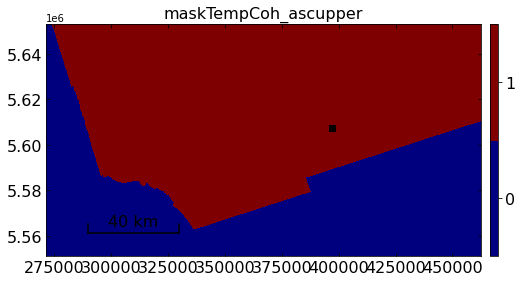

In [45]:
view.main(f'/home/micromamba/work/ascupper/maskTempCoh_ascupper.h5 --noverbose'.split())

## Set paths

In [46]:
data_paths = {'asclower':Path('../asclower').resolve(),
             'ascupper':Path('../ascupper').resolve(),
             'desclower':Path('../desclower').resolve(),
             'descupper':Path('../descupper').resolve()}

# data_paths = {'desc_lower':Path('../desc_lower').resolve(),
#              'desc_upper':Path('../desc_upper').resolve()}

## Create eroded mask file and mask datasets

In [92]:
for name in data_paths:
    print(name)
    p = data_paths[name]

    # mask_name = f'maskTempCoh_{name}_erd.h5'
    
    # Find files
    vels = list(p.glob('velocity*h5'))
    cohs = list(p.glob('temporalCoherence*h5'))
    tcoh_mask = p / f'maskTempCoh_{name}.h5'

    # Create new mask
    data, atr = readfile.read(tcoh_mask)
    erd = (morphology.binary_erosion(morphology.remove_small_holes(data,10), morphology.square(51))).astype(int)
    #     writefile.write({'mask':erd},mask_name,ref_file=tcoh_mask)
    
    for v in vels:
        name, ext = v.name.split('.')

        vel_name = f'{name}_mask.{ext}'
        vel, atr = readfile.read(v,datasetName='velocity')
        vel[erd == 0] = np.nan
        writefile.write({'velocity':vel},vel_name,ref_file=v)
        
        std_name = f'{name}_std_mask.{ext}'
        vel_std, atr = readfile.read(v,datasetName='velocityStd')
        vel_std[erd == 0] = np.nan
        writefile.write({'velocityStd':vel_std},std_name,ref_file=v)
        
    for c in cohs:
        name, ext = c.name.split('.')

        coh_name = f'{name}_mask.{ext}'
        coh, atr = readfile.read(c,datasetName='temporalCoherence')
        coh[erd == 0] = np.nan
        writefile.write({'temporalCoherence':coh},coh_name,ref_file=c)
        
    
#     # Mask velocity files
#     for v in vels:
#         name, ext = v.name.split('.')
#         vel_name = f'{name}_mask.{ext}'
#         if not Path(vel_name).exists():
#             !mask.py {str(v)} -m {mask_name} -o {vel_name}
    
#     # Mask coherence files
#     for c in cohs:
#         name, ext = c.name.split('.')
#         coh_name = f'{name}_mask.{ext}'
#         if not Path(coh_name).exists():
#             !mask.py {str(c)} -m {mask_name} -o {coh_name}

asclower
delete exsited file: velocity_asclower_2020_mask.h5
create HDF5 file: velocity_asclower_2020_mask.h5 with w mode
create dataset /velocity of float32    in size of (2394, 4120)         with compression=None
finished writing to velocity_asclower_2020_mask.h5
delete exsited file: velocity_asclower_2020_std_mask.h5
create HDF5 file: velocity_asclower_2020_std_mask.h5 with w mode
create dataset /velocityStd of float32    in size of (2394, 4120)         with compression=None
finished writing to velocity_asclower_2020_std_mask.h5
delete exsited file: velocity_asclower_2018_mask.h5
create HDF5 file: velocity_asclower_2018_mask.h5 with w mode
create dataset /velocity of float32    in size of (2394, 4120)         with compression=None
finished writing to velocity_asclower_2018_mask.h5
delete exsited file: velocity_asclower_2018_std_mask.h5
create HDF5 file: velocity_asclower_2018_std_mask.h5 with w mode
create dataset /velocityStd of float32    in size of (2394, 4120)         with compr

## Merge ascending and descending velocity by year

In [93]:
# plotting results may need to be disabled at line 279 of image_stitch.py
for track, year in product(tracks,years):
    vel_pattern = f'velocity_{track}*{year}_mask.h5'
    vel_name = f'velocity_{track}{year}.h5'
    !image_stitch.py {vel_pattern} -o {vel_name} --no-offset
    
    std_pattern = f'velocity_{track}*{year}_std_mask.h5'
    std_name = f'std_{track}{year}.h5'
    !image_stitch.py {std_pattern} -o {std_name} --no-offset
    
    coh_pattern = f'temporalCoherence_{track}*{year}_mask.h5'
    coh_name = f'temporalCoherence_{track}{year}.h5'
    !image_stitch.py {coh_pattern} -o {coh_name} --no-offset

    # std_name = f'std_{track}{year}.h5'
    # !image_stitch.py {vel_pattern} -o {std_name} -d velocityStd --no-offset

    # temp_cohs = Path('..').glob(f'*/temporalCoherence_{track}*{year}.h5')
    # temp_cohs = ' '.join([str(x.resolve()) for x in temp_cohs])
    # temp_coh_name = f'temporalCoherence_{track}{year}.h5'
    # !image_stitch.py {temp_cohs} -o {temp_coh_name} --no-offset

    # !image_stitch.py {vel_pattern} -o {std_name} -d velocityStd --no-offset
    # !image_stitch.py {temp_cohs} -o {temp_coh_name} --no-offset

files to be stitched:
	velocity_asclower_2018_mask.h5
	velocity_ascupper_2018_mask.h5
read data from file: velocity_asclower_2018_mask.h5
--------------------------------------------------
read data from file: velocity_ascupper_2018_mask.h5
stitching ...
grab corners of input matrices
calculate corners of output matrix
estimate difference in the overlaping area
create output metadata and matrix in shape of (2572, 4782)
--------------------------------------------------
delete exsited file: velocity_asc2018.h5
create HDF5 file: velocity_asc2018.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_asc2018.h5
files to be stitched:
	velocity_asclower_2018_std_mask.h5
	velocity_ascupper_2018_std_mask.h5
read data from file: velocity_asclower_2018_std_mask.h5
--------------------------------------------------
read data from file: velocity_ascupper_2018_std_mask.h5
stitching ...
grab corners of input matrices


## Project from ascending/descending orbit to E-W/Up-Down

In [101]:
for year in years:
    asc_vel = f'velocity_asc{year}.h5'
    desc_vel = f'velocity_desc{year}.h5'
    
    asc_std = f'std_asc{year}.h5'
    desc_std = f'std_desc{year}.h5'
    
    up_vel = f'velocity_up{year}.h5'
    ew_vel = f'velocity_ew{year}.h5'

    up_std = f'std_up{year}.h5'    
    ew_std = f'std_ew{year}.h5'

    !asc_desc2horz_vert.py {asc_vel} {desc_vel} -o {ew_vel} {up_vel} --max-ref-yx-diff 10000
    !asc_desc2horz_vert.py {asc_std} {desc_std} -o {ew_std} {up_std} --max-ref-yx-diff 10000

---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 462640.0)
read from file: velocity_asc2018.h5
read from file: velocity_desc2018.h5
---------------------
get design matrix
LOS incidence angle: 35.66832225719844 deg
LOS azimuth angle: 103.83512539999998 deg
LOS incidence angle: 35.77095461818939 deg
LOS azimuth angle: -103.77717740000003 deg
project asc/desc into horz/vert direction
---------------------
writing horizontal component to file: velocity_ew2018.h5
create HDF5 file: velocity_ew2018.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_ew2018.h5
writing   vertical component to file: velocity_up2018.h5
create HDF5 file: velocity_up2018.h5 with w mode
create dataset /velocity of float32    in size of (2572, 4782)         with compression=None
finished writing to velocity_up2018.h5
Done.
---------------------
common area in SNWE: (5550080.0, 5652960.0, 271360.0, 462640.0

In [102]:
for year in years:
    image1, image2 = f'temporalCoherence_asc{year}.h5 temporalCoherence_desc{year}.h5'.split(' ')
    out_name = f'temporalCoherence_avg{year}.h5'

    !generate_mask.py {str(image1)} -m 0 -o image1_mask.h5
    !generate_mask.py {str(image2)} -m 0 -o image2_mask.h5
    !add.py image1_mask.h5 image2_mask.h5 -o maskAdd.h5
    !generate_mask.py maskAdd.h5 -m 2 -o mask.h5
    
    !add.py {image1} {image2} -o tempCohAdd.h5
    !image_math.py tempCohAdd.h5 '/' 2 -o tempCohAvg.h5
    !mask.py tempCohAvg.h5 -m mask.h5 -o {out_name}

!rm tempCohAdd.h5 image1_mask.h5 image2_mask.h5 maskAdd.h5 tempCohAvg.h5 mask.h5

input temporalCoherence file: temporalCoherence_asc2018.h5
read temporalCoherence_asc2018.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.0
create HDF5 file: image1_mask.h5 with w mode
create dataset /mask of bool       in size of (2572, 4782)         with compression=None
finished writing to image1_mask.h5
time used: 00 mins 0.2 secs.
input temporalCoherence file: temporalCoherence_desc2018.h5
read temporalCoherence_desc2018.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.0
create HDF5 file: image2_mask.h5 with w mode
create dataset /mask of bool       in size of (2572, 4782)         with compression=None
finished writing to image2_mask.h5
time used: 00 mins 0.2 secs.
input files to be added: (2)
['image1_mask.h5', 'image2_mask.h5']
adding mask ...
use metadata from the 1st file: image1_mask.h5
create HDF5 file: maskAdd

## Check Results

In [106]:
dset = 'temporalCoherence_avg2019.h5'

view.py temporalCoherence_avg2019.h5 --noverbose


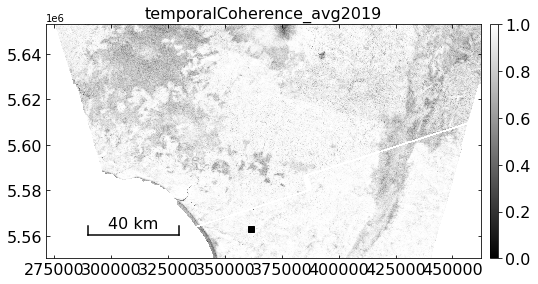

In [107]:
view.main(f'{dset} --noverbose'.split(' '))

In [108]:
!info.py {dset}

******************** Basic File Info ************************
file name: /home/micromamba/work/combined/temporalCoherence_avg2019.h5
file type: temporalCoherence
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                     2
  ANTENNA_SIDE                               -1
  AZIMUTH_PIXEL_SIZE                         28.2
  BANDS                                      1
  CENTER_LINE_UTC                            25591.389594
  DATA_TYPE                                  float32
  DATE12                                     170116-170209
  EARTH_RADIUS                               6369244.3101
  END_DATE                                   20211028
  EPSG                                       32760
  FILE_LENGTH                                6869
  FILE_PATH                                  /home/micromamba/work/combined/tempCohAvg.h5
  FILE_TYPE                                  temporalCoherence
  HEAD

## Export to Geotiffs

In [109]:
vels = list(Path().glob('velocity_*[ascdesc]20*.h5'))
vels_proj = list(Path().glob('velocity_*[ewup]20*.h5'))
cohs = list(Path().glob('temporalCoherence_*[ascdesc]20*.h5'))
cohs_proj = list(Path().glob('temporalCoherence_avg20*.h5'))
stds = list(Path().glob('std_*[ascdesc]_20*.h5'))
stds_proj = list(Path().glob('std_*[ewup]20*.h5'))

# files = vels + cohs
files = vels + vels_proj + cohs + cohs_proj + stds + stds_proj

files

[PosixPath('velocity_asc2019.h5'),
 PosixPath('velocity_desc2020.h5'),
 PosixPath('velocity_asc2020.h5'),
 PosixPath('velocity_desc2021.h5'),
 PosixPath('velocity_asc2018.h5'),
 PosixPath('velocity_desc2018.h5'),
 PosixPath('velocity_asc2021.h5'),
 PosixPath('velocity_desc2019.h5'),
 PosixPath('velocity_ew2021.h5'),
 PosixPath('velocity_up2020.h5'),
 PosixPath('velocity_up2019.h5'),
 PosixPath('velocity_ew2019.h5'),
 PosixPath('velocity_ew2018.h5'),
 PosixPath('velocity_up2018.h5'),
 PosixPath('velocity_ew2020.h5'),
 PosixPath('velocity_up2021.h5'),
 PosixPath('temporalCoherence_asc2018.h5'),
 PosixPath('temporalCoherence_asc2019.h5'),
 PosixPath('temporalCoherence_desc2020.h5'),
 PosixPath('temporalCoherence_desc2019.h5'),
 PosixPath('temporalCoherence_asc2021.h5'),
 PosixPath('temporalCoherence_asc2020.h5'),
 PosixPath('temporalCoherence_desc2018.h5'),
 PosixPath('temporalCoherence_desc2021.h5'),
 PosixPath('temporalCoherence_avg2021.h5'),
 PosixPath('temporalCoherence_avg2018.h5'),


In [110]:
for f in files:
    outfile = str(Path('../results') / f.with_suffix('.tif'))
    !save_gdal.py {str(f)} -o {outfile}

read metadata from file: velocity_asc2019.h5
read data     from file: velocity_asc2019.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/work/results/velocity_asc2019.tif
read metadata from file: velocity_desc2020.h5
read data     from file: velocity_desc2020.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /home/micromamba/work/results/velocity_desc2020.tif
read metadata from file: velocity_asc2020.h5
read data     from file: velocity_asc2020.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 2572, 4782
raster transform info: (271360.0, 40.0, 0, 5652960.0, 0, -40.0)
write data to ras

## Done!

In [111]:
!ls *mask*h5

maskTempCoh_asclower_erd.h5		  velocity_asclower_2021_mask.h5
maskTempCoh_ascupper_erd.h5		  velocity_asclower_2021_std_mask.h5
maskTempCoh_desclower_erd.h5		  velocity_ascupper_2018_mask.h5
maskTempCoh_descupper_erd.h5		  velocity_ascupper_2018_std_mask.h5
temporalCoherence_asclower_2018_mask.h5   velocity_ascupper_2019_mask.h5
temporalCoherence_asclower_2019_mask.h5   velocity_ascupper_2019_std_mask.h5
temporalCoherence_asclower_2020_mask.h5   velocity_ascupper_2020_mask.h5
temporalCoherence_asclower_2021_mask.h5   velocity_ascupper_2020_std_mask.h5
temporalCoherence_ascupper_2018_mask.h5   velocity_ascupper_2021_mask.h5
temporalCoherence_ascupper_2019_mask.h5   velocity_ascupper_2021_std_mask.h5
temporalCoherence_ascupper_2020_mask.h5   velocity_desclower_2018_mask.h5
temporalCoherence_ascupper_2021_mask.h5   velocity_desclower_2018_std_mask.h5
temporalCoherence_desclower_2018_mask.h5  velocity_desclower_2019_mask.h5
temporalCoherence_desclower_2019_mask.h5  velocity_desclower_2019_

In [112]:
!rm *mask*h5